In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import learning_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1, l2, l1_l2
import os
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Cell 2: Define the CreditCardFraudDetectionANN class
class CreditCardFraudDetectionANN:
    def __init__(self):
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.model = None
        self.results = {}
        self.best_params = {}
        self.data_loaded = False
        self.history = None
        
    def create_directories(self):
        """Create necessary directories for saving plots"""
        os.makedirs('../img/ann/', exist_ok=True)
        print("Created directories for saving plots")
        
    def load_data(self):
        """Load and preprocess the credit card fraud dataset with multiple fallbacks"""
        print("Loading dataset...")
        
        # Try multiple URLs and methods
        urls = [
            "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv",
            "https://media.githubusercontent.com/media/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
        ]
        
        # Try direct pandas read first
        for url in urls:
            try:
                self.data = pd.read_csv(url)
                print(f"Dataset loaded successfully from: {url}")
                self.data_loaded = True
                break
            except Exception as e:
                print(f"Failed to load from {url}: {e}")
                continue
        
        # If online loading fails, check for local file
        if not self.data_loaded:
            local_paths = [
                "creditcard.csv",
                "../creditcard.csv", 
                "../../creditcard.csv",
                "data/creditcard.csv"
            ]
            for local_path in local_paths:
                if os.path.exists(local_path):
                    try:
                        self.data = pd.read_csv(local_path)
                        print(f"Dataset loaded successfully from local file: {local_path}")
                        self.data_loaded = True
                        break
                    except Exception as e:
                        print(f"Failed to load from {local_path}: {e}")
                        continue
        
        # If all methods fail, create sample data for demonstration
        if not self.data_loaded:
            print("Warning: Could not load dataset from any source. Creating sample data for demonstration.")
            self.create_sample_data()
            self.data_loaded = True
        
        if self.data_loaded:
            print(f"Dataset shape: {self.data.shape}")
            print(f"Fraud cases: {self.data['Class'].sum()} ({self.data['Class'].mean()*100:.2f}%)")
            
            # Separate features and target
            X = self.data.drop('Class', axis=1)
            y = self.data['Class']
            
            # Split the data
            self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            
            # Scale the features (very important for ANN)
            self.X_train_scaled = self.scaler.fit_transform(self.X_train)
            self.X_test_scaled = self.scaler.transform(self.X_test)
            
            print(f"Training set: {self.X_train_scaled.shape}")
            print(f"Test set: {self.X_test_scaled.shape}")
            
            return X, y
        else:
            print("Error: Could not load or create dataset.")
            return None, None
    
    def create_sample_data(self):
        """Create sample data for demonstration if download fails"""
        np.random.seed(42)
        n_samples = 10000
        n_features = 30
        
        # Create synthetic features similar to credit card data
        features = np.random.randn(n_samples, n_features)
        
        # Create target with class imbalance (0.17% fraud)
        fraud_indices = np.random.choice(n_samples, size=int(n_samples * 0.0017), replace=False)
        target = np.zeros(n_samples)
        target[fraud_indices] = 1
        
        # Create feature names
        feature_names = [f'V{i+1}' for i in range(28)] + ['Amount', 'Time']
        
        self.data = pd.DataFrame(features, columns=feature_names)
        self.data['Class'] = target.astype(int)
        
        print("Created synthetic dataset for demonstration purposes")
        print("Note: This is synthetic data. For real results, please download the actual dataset.")
    
    def analyze_class_imbalance(self):
        """Analyze and visualize class imbalance"""
        if not self.data_loaded:
            print("No data available for analysis.")
            return
            
        print("\n" + "="*60)
        print("Class Imbalance Analysis")
        print("="*60)
        
        class_counts = self.data['Class'].value_counts()
        print(f"Genuine transactions: {class_counts[0]} ({class_counts[0]/len(self.data)*100:.2f}%)")
        print(f"Fraud transactions: {class_counts[1]} ({class_counts[1]/len(self.data)*100:.2f}%)")
        
        # Plot class distribution
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        class_counts.plot(kind='bar', color=['skyblue', 'coral'])
        plt.title('Class Distribution')
        plt.xlabel('Class (0: Genuine, 1: Fraud)')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        
        plt.subplot(1, 2, 2)
        plt.pie(class_counts, labels=['Genuine', 'Fraud'], autopct='%1.2f%%', 
                colors=['skyblue', 'coral'], startangle=90)
        plt.title('Class Distribution (%)')
        
        plt.tight_layout()
        plt.show()
    
    def create_ann_model(self, hidden_layers=[64, 32], activation='relu', dropout_rate=0.3, 
                        learning_rate=0.001, optimizer='adam', regularization=None):
        """Create ANN model with specified architecture"""
        model = Sequential()
        
        # Input layer
        model.add(Dense(hidden_layers[0], activation=activation, 
                       input_shape=(self.X_train_scaled.shape[1],),
                       kernel_regularizer=regularization))
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))
        
        # Hidden layers
        for units in hidden_layers[1:]:
            model.add(Dense(units, activation=activation, 
                           kernel_regularizer=regularization))
            model.add(BatchNormalization())
            model.add(Dropout(dropout_rate))
        
        # Output layer
        model.add(Dense(1, activation='sigmoid'))
        
        # Compile model
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'rmsprop':
            opt = RMSprop(learning_rate=learning_rate)
        elif optimizer == 'sgd':
            opt = SGD(learning_rate=learning_rate, momentum=0.9)
        else:
            opt = Adam(learning_rate=learning_rate)
        
        model.compile(optimizer=opt,
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
        
        return model
    
    def train_ann(self, hidden_layers=[64, 32], activation='relu', dropout_rate=0.3,
                 learning_rate=0.001, optimizer='adam', batch_size=32, epochs=50,
                 regularization=None, class_weight=None):
        """Train ANN model with given parameters"""
        print(f"ANN: layers={hidden_layers}, activation={activation}, "
              f"dropout={dropout_rate}, lr={learning_rate}, optimizer={optimizer}, "
              f"batch_size={batch_size}")
        
        # Create model
        self.model = self.create_ann_model(
            hidden_layers=hidden_layers,
            activation=activation,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate,
            optimizer=optimizer,
            regularization=regularization
        )
        
        # Callbacks
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
        ]
        
        # Calculate class weights if specified
        if class_weight == 'balanced':
            from sklearn.utils.class_weight import compute_class_weight
            classes = np.unique(self.y_train)
            weights = compute_class_weight('balanced', classes=classes, y=self.y_train)
            class_weight_dict = dict(zip(classes, weights))
        else:
            class_weight_dict = None
        
        # Train model
        self.history = self.model.fit(
            self.X_train_scaled, self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.2,
            callbacks=callbacks,
            class_weight=class_weight_dict,
            verbose=0
        )
        
        # Make predictions
        y_train_pred_proba = self.model.predict(self.X_train_scaled, verbose=0)
        y_test_pred_proba = self.model.predict(self.X_test_scaled, verbose=0)
        
        y_train_pred = (y_train_pred_proba > 0.5).astype(int).flatten()
        y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()
        
        # Calculate metrics
        train_accuracy = accuracy_score(self.y_train, y_train_pred)
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        train_precision = precision_score(self.y_train, y_train_pred, zero_division=0)
        test_precision = precision_score(self.y_test, y_test_pred, zero_division=0)
        train_recall = recall_score(self.y_train, y_train_pred)
        test_recall = recall_score(self.y_test, y_test_pred)
        train_f1 = f1_score(self.y_train, y_train_pred)
        test_f1 = f1_score(self.y_test, y_test_pred)
        
        # Store results
        param_key = f"layers{hidden_layers}_act{activation}_drop{dropout_rate}_lr{learning_rate}_opt{optimizer}_bs{batch_size}"
        self.results[param_key] = {
            'hidden_layers': hidden_layers,
            'activation': activation,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'optimizer': optimizer,
            'batch_size': batch_size,
            'regularization': str(regularization),
            'class_weight': class_weight,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'train_precision': train_precision,
            'test_precision': test_precision,
            'train_recall': train_recall,
            'test_recall': test_recall,
            'train_f1': train_f1,
            'test_f1': test_f1,
            'y_test_proba': y_test_pred_proba.flatten(),
            'history': self.history.history
        }
        
        print(f"Train F1: {train_f1:.4f}, Test F1: {test_f1:.4f}")
        print(f"Train Precision: {train_precision:.4f}, Test Precision: {test_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f}, Test Recall: {test_recall:.4f}")
        
        return self.results[param_key]
    
    def hyperparameter_tuning_focused(self):
        """Reduced hyperparameter tuning for ANN - Only 24 combinations"""
        print("\n" + "="*60)
        print("Reduced Hyperparameter Tuning (24 combinations)")
        print("="*60)
        
        # Reduced parameter grid for faster execution
        param_grid = {
            'hidden_layers': [[64, 32], [128, 64]],  # Reduced from 3 to 2
            'activation': ['relu'],                   # Only relu (most common)
            'dropout_rate': [0.3, 0.5],              # Reduced from 3 to 2
            'learning_rate': [0.001],                # Only 0.001 (most common)
            'optimizer': ['adam'],                   # Only adam (most common)
            'batch_size': [32, 64],                  # Reduced from 2 to 2
            'class_weight': [None, 'balanced']       # Keep both options
        }
        
        best_score = 0
        best_params = {}
        
        total_combinations = (len(param_grid['hidden_layers']) * 
                            len(param_grid['activation']) * 
                            len(param_grid['dropout_rate']) * 
                            len(param_grid['learning_rate']) * 
                            len(param_grid['optimizer']) * 
                            len(param_grid['batch_size']) * 
                            len(param_grid['class_weight']))
        current_combination = 0
        
        print(f"Testing {total_combinations} parameter combinations (reduced from 288)")
        print("-" * 80)
        
        for hidden_layers in param_grid['hidden_layers']:
            for activation in param_grid['activation']:
                for dropout_rate in param_grid['dropout_rate']:
                    for learning_rate in param_grid['learning_rate']:
                        for optimizer in param_grid['optimizer']:
                            for batch_size in param_grid['batch_size']:
                                for class_weight in param_grid['class_weight']:
                                    current_combination += 1
                                    print(f"[{current_combination}/{total_combinations}] ", end="")
                                    
                                    try:
                                        results = self.train_ann(
                                            hidden_layers=hidden_layers,
                                            activation=activation,
                                            dropout_rate=dropout_rate,
                                            learning_rate=learning_rate,
                                            optimizer=optimizer,
                                            batch_size=batch_size,
                                            epochs=50,
                                            class_weight=class_weight
                                        )
                                        
                                        # Use F1-score as the main metric
                                        current_score = results['test_f1']
                                        if current_score > best_score:
                                            best_score = current_score
                                            best_params = {
                                                'hidden_layers': hidden_layers,
                                                'activation': activation,
                                                'dropout_rate': dropout_rate,
                                                'learning_rate': learning_rate,
                                                'optimizer': optimizer,
                                                'batch_size': batch_size,
                                                'class_weight': class_weight,
                                                'results': results
                                            }
                                            print(f" *** New best F1: {best_score:.4f} ***")
                                        else:
                                            print(f"F1: {current_score:.4f}")
                                            
                                    except Exception as e:
                                        print(f"Failed: {e}")
                                        continue
        
        if best_params:
            print(f"\n{'='*60}")
            print("*** BEST PARAMETERS FOUND ***")
            print(f"{'='*60}")
            print(f"Best hidden_layers: {best_params['hidden_layers']}")
            print(f"Best activation: {best_params['activation']}")
            print(f"Best dropout_rate: {best_params['dropout_rate']}")
            print(f"Best learning_rate: {best_params['learning_rate']}")
            print(f"Best optimizer: {best_params['optimizer']}")
            print(f"Best batch_size: {best_params['batch_size']}")
            print(f"Best class_weight: {best_params['class_weight']}")
            print(f"Best F1-Score: {best_score:.4f}")
            
            self.best_params = best_params
            return best_params
        else:
            print("No valid results obtained from hyperparameter tuning.")
            return None
    
    def plot_training_history(self, history):
        """Plot training history (loss and accuracy)"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot training & validation loss
        ax1.plot(history['loss'], label='Training Loss')
        ax1.plot(history['val_loss'], label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot training & validation accuracy
        ax2.plot(history['accuracy'], label='Training Accuracy')
        ax2.plot(history['val_accuracy'], label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_hyperparameter_analysis(self):
        """Plot analysis of hyperparameter effects"""
        if not self.results:
            print("No results to plot. Please train the model first.")
            return
        
        # Prepare data for plotting
        hidden_layers_list = []
        activations = []
        dropout_rates = []
        learning_rates = []
        optimizers = []
        batch_sizes = []
        class_weights = []
        test_f1_scores = []
        test_precisions = []
        test_recalls = []
        
        for param_key, result in self.results.items():
            hidden_layers_list.append(str(result['hidden_layers']))
            activations.append(result['activation'])
            dropout_rates.append(result['dropout_rate'])
            learning_rates.append(result['learning_rate'])
            optimizers.append(result['optimizer'])
            batch_sizes.append(result['batch_size'])
            class_weights.append(str(result['class_weight']))
            test_f1_scores.append(result['test_f1'])
            test_precisions.append(result['test_precision'])
            test_recalls.append(result['test_recall'])
        
        # Create DataFrame for easier plotting
        results_df = pd.DataFrame({
            'hidden_layers': hidden_layers_list,
            'activation': activations,
            'dropout_rate': dropout_rates,
            'learning_rate': learning_rates,
            'optimizer': optimizers,
            'batch_size': batch_sizes,
            'class_weight': class_weights,
            'f1_score': test_f1_scores,
            'precision': test_precisions,
            'recall': test_recalls
        })
        
        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Hidden layers vs F1-score
        layers_data = results_df[['hidden_layers', 'f1_score']].copy()
        layers_groups = layers_data.groupby('hidden_layers')['f1_score'].mean().reset_index()
        
        # Simplify layer names for plotting
        layers_groups['layer_simple'] = layers_groups['hidden_layers'].apply(
            lambda x: f"{len(eval(x))}L" if '[' in x else '1L'
        )
        
        simple_groups = layers_groups.groupby('layer_simple')['f1_score'].mean().reset_index()
        axes[0,0].bar(simple_groups['layer_simple'], simple_groups['f1_score'], alpha=0.8, color='skyblue')
        axes[0,0].set_xlabel('Number of Hidden Layers')
        axes[0,0].set_ylabel('F1-Score')
        axes[0,0].set_title('Number of Hidden Layers vs F1-Score')
        axes[0,0].grid(True, alpha=0.3)
        
        # Plot 2: Activation function comparison
        activation_data = results_df[['activation', 'f1_score', 'precision', 'recall']].copy()
        activation_groups = activation_data.groupby('activation').agg({
            'f1_score': 'mean',
            'precision': 'mean',
            'recall': 'mean'
        }).reset_index()
        
        metrics = ['f1_score', 'precision', 'recall']
        metric_names = ['F1-Score', 'Precision', 'Recall']
        x_pos = np.arange(len(metrics))
        width = 0.35
        
        if len(activation_groups) > 0:
            for i, activation in enumerate(activation_groups['activation']):
                scores = [activation_groups[activation_groups['activation'] == activation][metric].values[0] for metric in metrics]
                axes[0,1].bar(x_pos + (i - len(activation_groups)/2 + 0.5) * width, scores, width, 
                             label=activation, alpha=0.8)
        
        axes[0,1].set_xlabel('Metrics')
        axes[0,1].set_ylabel('Score')
        axes[0,1].set_title('Activation Function Comparison')
        axes[0,1].set_xticks(x_pos)
        axes[0,1].set_xticklabels(metric_names)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Plot 3: Dropout rate vs F1-score
        dropout_data = results_df[['dropout_rate', 'f1_score']].copy()
        dropout_groups = dropout_data.groupby('dropout_rate')['f1_score'].mean().reset_index()
        axes[0,2].plot(dropout_groups['dropout_rate'], dropout_groups['f1_score'], 
                      marker='o', linewidth=2, color='green')
        axes[0,2].set_xlabel('Dropout Rate')
        axes[0,2].set_ylabel('F1-Score')
        axes[0,2].set_title('Dropout Rate vs F1-Score')
        axes[0,2].grid(True, alpha=0.3)
        
        # Plot 4: Learning rate comparison
        lr_data = results_df[['learning_rate', 'f1_score', 'precision', 'recall']].copy()
        lr_groups = lr_data.groupby('learning_rate').agg({
            'f1_score': 'mean',
            'precision': 'mean',
            'recall': 'mean'
        }).reset_index()
        
        if len(lr_groups) > 0:
            for i, lr in enumerate(lr_groups['learning_rate']):
                scores = [lr_groups[lr_groups['learning_rate'] == lr][metric].values[0] for metric in metrics]
                axes[1,0].bar(x_pos + (i - len(lr_groups)/2 + 0.5) * width, scores, width, 
                             label=str(lr), alpha=0.8)
        
        axes[1,0].set_xlabel('Metrics')
        axes[1,0].set_ylabel('Score')
        axes[1,0].set_title('Learning Rate Comparison')
        axes[1,0].set_xticks(x_pos)
        axes[1,0].set_xticklabels(metric_names)
        axes[1,0].legend(title='Learning Rate')
        axes[1,0].grid(True, alpha=0.3)
        
        # Plot 5: Optimizer comparison
        optimizer_data = results_df[['optimizer', 'f1_score', 'precision', 'recall']].copy()
        optimizer_groups = optimizer_data.groupby('optimizer').agg({
            'f1_score': 'mean',
            'precision': 'mean',
            'recall': 'mean'
        }).reset_index()
        
        if len(optimizer_groups) > 0:
            for i, optimizer in enumerate(optimizer_groups['optimizer']):
                scores = [optimizer_groups[optimizer_groups['optimizer'] == optimizer][metric].values[0] for metric in metrics]
                axes[1,1].bar(x_pos + (i - len(optimizer_groups)/2 + 0.5) * width, scores, width, 
                             label=optimizer, alpha=0.8)
        
        axes[1,1].set_xlabel('Metrics')
        axes[1,1].set_ylabel('Score')
        axes[1,1].set_title('Optimizer Comparison')
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(metric_names)
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        # Plot 6: Precision-Recall trade-off
        scatter = axes[1,2].scatter(results_df['precision'], results_df['recall'], 
                                   c=results_df['f1_score'], s=50, alpha=0.7, cmap='viridis')
        axes[1,2].set_xlabel('Precision')
        axes[1,2].set_ylabel('Recall')
        axes[1,2].set_title('Precision-Recall Trade-off (Color: F1-Score)')
        axes[1,2].grid(True, alpha=0.3)
        plt.colorbar(scatter, ax=axes[1,2], label='F1-Score')
        
        plt.tight_layout()
        plt.show()
    
    def plot_confusion_matrix_comprehensive(self):
        """Plot comprehensive confusion matrix and metrics"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        # Train best model
        best_results = self.best_params['results']
        best_hidden_layers = self.best_params['hidden_layers']
        best_activation = self.best_params['activation']
        best_dropout_rate = self.best_params['dropout_rate']
        best_learning_rate = self.best_params['learning_rate']
        best_optimizer = self.best_params['optimizer']
        best_batch_size = self.best_params['batch_size']
        
        # Recreate and train best model
        self.model = self.create_ann_model(
            hidden_layers=best_hidden_layers,
            activation=best_activation,
            dropout_rate=best_dropout_rate,
            learning_rate=best_learning_rate,
            optimizer=best_optimizer
        )
        
        # Calculate class weights if specified
        if self.best_params['class_weight'] == 'balanced':
            from sklearn.utils.class_weight import compute_class_weight
            classes = np.unique(self.y_train)
            weights = compute_class_weight('balanced', classes=classes, y=self.y_train)
            class_weight_dict = dict(zip(classes, weights))
        else:
            class_weight_dict = None
        
        # Train with best parameters
        self.model.fit(
            self.X_train_scaled, self.y_train,
            batch_size=best_batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            class_weight=class_weight_dict,
            verbose=0
        )
        
        y_pred_proba = self.model.predict(self.X_test_scaled, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        cm = confusion_matrix(self.y_test, y_pred)
        
        # Create comprehensive plot
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Confusion Matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                   xticklabels=['Genuine', 'Fraud'], 
                   yticklabels=['Genuine', 'Fraud'])
        ax1.set_title(f'Confusion Matrix\nLayers: {best_hidden_layers}, Activation: {best_activation}')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # Metrics Summary
        metrics_text = f"""
        Best Parameters:
        - Hidden Layers: {best_hidden_layers}
        - Activation: {best_activation}
        - Dropout Rate: {best_dropout_rate}
        - Learning Rate: {best_learning_rate}
        - Optimizer: {best_optimizer}
        - Batch Size: {best_batch_size}
        - Class Weight: {self.best_params['class_weight']}
        
        Performance Metrics:
        - Test Accuracy:  {best_results['test_accuracy']:.4f}
        - Test Precision: {best_results['test_precision']:.4f}
        - Test Recall:    {best_results['test_recall']:.4f}
        - Test F1-Score:  {best_results['test_f1']:.4f}
        
        Training Performance:
        - Train Accuracy:  {best_results['train_accuracy']:.4f}
        - Train Precision: {best_results['train_precision']:.4f}
        - Train Recall:    {best_results['train_recall']:.4f}
        - Train F1-Score:  {best_results['train_f1']:.4f}
        """
        
        ax2.text(0.1, 0.9, metrics_text, fontsize=10, fontfamily='monospace',
                verticalalignment='top', transform=ax2.transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title('Model Performance Summary')
        
        plt.tight_layout()
        plt.show()
    
    def plot_roc_pr_curves(self):
        """Plot ROC and Precision-Recall curves"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_results = self.best_params['results']
        y_test_proba = best_results['y_test_proba']
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(self.y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(self.y_test, y_test_proba)
        pr_auc = auc(recall, precision)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # ROC Curve
        ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
        ax1.set_xlim([0.0, 1.0])
        ax1.set_ylim([0.0, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
        ax1.legend(loc="lower right")
        ax1.grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        ax2.plot(recall, precision, color='green', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title('Precision-Recall Curve')
        ax2.legend(loc="lower left")
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def print_comprehensive_report(self):
        """Print comprehensive classification report"""
        if not self.best_params:
            print("No best parameters found. Please run hyperparameter tuning first.")
            return
        
        best_hidden_layers = self.best_params['hidden_layers']
        best_activation = self.best_params['activation']
        best_dropout_rate = self.best_params['dropout_rate']
        best_learning_rate = self.best_params['learning_rate']
        best_optimizer = self.best_params['optimizer']
        best_batch_size = self.best_params['batch_size']
        best_class_weight = self.best_params['class_weight']
        best_results = self.best_params['results']
        
        print("\n" + "="*60)
        print("COMPREHENSIVE CLASSIFICATION REPORT")
        print("="*60)
        print(f"Best Parameters:")
        print(f"  - Hidden Layers: {best_hidden_layers}")
        print(f"  - Activation: {best_activation}")
        print(f"  - Dropout Rate: {best_dropout_rate}")
        print(f"  - Learning Rate: {best_learning_rate}")
        print(f"  - Optimizer: {best_optimizer}")
        print(f"  - Batch Size: {best_batch_size}")
        print(f"  - Class Weight: {best_class_weight}")
        
        # Recreate and train best model for final predictions
        self.model = self.create_ann_model(
            hidden_layers=best_hidden_layers,
            activation=best_activation,
            dropout_rate=best_dropout_rate,
            learning_rate=best_learning_rate,
            optimizer=best_optimizer
        )
        
        # Calculate class weights if specified
        if best_class_weight == 'balanced':
            from sklearn.utils.class_weight import compute_class_weight
            classes = np.unique(self.y_train)
            weights = compute_class_weight('balanced', classes=classes, y=self.y_train)
            class_weight_dict = dict(zip(classes, weights))
        else:
            class_weight_dict = None
        
        # Train with best parameters
        self.model.fit(
            self.X_train_scaled, self.y_train,
            batch_size=best_batch_size,
            epochs=50,
            validation_split=0.2,
            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
            class_weight=class_weight_dict,
            verbose=0
        )
        
        y_pred_proba = self.model.predict(self.X_test_scaled, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
        print("\n" + classification_report(self.y_test, y_pred, target_names=['Genuine', 'Fraud']))
        
        print(f"\nTest Set Performance:")
        print(f"Accuracy:  {best_results['test_accuracy']:.4f}")
        print(f"Precision: {best_results['test_precision']:.4f}")
        print(f"Recall:    {best_results['test_recall']:.4f}")
        print(f"F1-Score:  {best_results['test_f1']:.4f}")

print("CreditCardFraudDetectionANN class defined successfully!")

CreditCardFraudDetectionANN class defined successfully!


In [3]:
# Cell 3: Initialize the fraud detection system and load data
fraud_detector = CreditCardFraudDetectionANN()

# Create directories first
fraud_detector.create_directories()

# Load and preprocess data
data_loaded = fraud_detector.load_data()

if not fraud_detector.data_loaded:
    print("\nTo use the real dataset, please:")
    print("1. Download 'creditcard.csv' from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud")
    print("2. Place it in the same directory as this script")
    print("3. Run the script again")
    print("\nFor now, using synthetic data for demonstration...")

Created directories for saving plots
Loading dataset...
Dataset loaded successfully from: https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv
Dataset shape: (284807, 31)
Fraud cases: 492 (0.17%)
Training set: (227845, 30)
Test set: (56962, 30)



Class Imbalance Analysis
Genuine transactions: 284315 (99.83%)
Fraud transactions: 492 (0.17%)


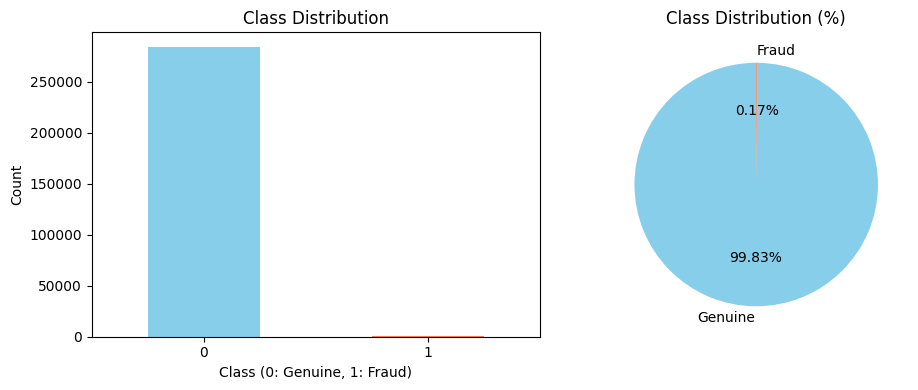

In [4]:
# Cell 4: Analyze class imbalance
fraud_detector.analyze_class_imbalance()

In [5]:
# Cell 5: Perform focused hyperparameter tuning
best_params = fraud_detector.hyperparameter_tuning_focused()


Reduced Hyperparameter Tuning (24 combinations)
Testing 16 parameter combinations (reduced from 288)
--------------------------------------------------------------------------------
[1/16] ANN: layers=[64, 32], activation=relu, dropout=0.3, lr=0.001, optimizer=adam, batch_size=32
Train F1: 0.8220, Test F1: 0.7902
Train Precision: 0.8295, Test Precision: 0.7570
Train Recall: 0.8147, Test Recall: 0.8265
 *** New best F1: 0.7902 ***
[2/16] ANN: layers=[64, 32], activation=relu, dropout=0.3, lr=0.001, optimizer=adam, batch_size=32
Train F1: 0.2752, Test F1: 0.2620
Train Precision: 0.1615, Test Precision: 0.1537
Train Recall: 0.9315, Test Recall: 0.8878
F1: 0.2620
[3/16] ANN: layers=[64, 32], activation=relu, dropout=0.3, lr=0.001, optimizer=adam, batch_size=64
Train F1: 0.8371, Test F1: 0.8122
Train Precision: 0.8753, Test Precision: 0.8081
Train Recall: 0.8020, Test Recall: 0.8163
 *** New best F1: 0.8122 ***
[4/16] ANN: layers=[64, 32], activation=relu, dropout=0.3, lr=0.001, optimizer=

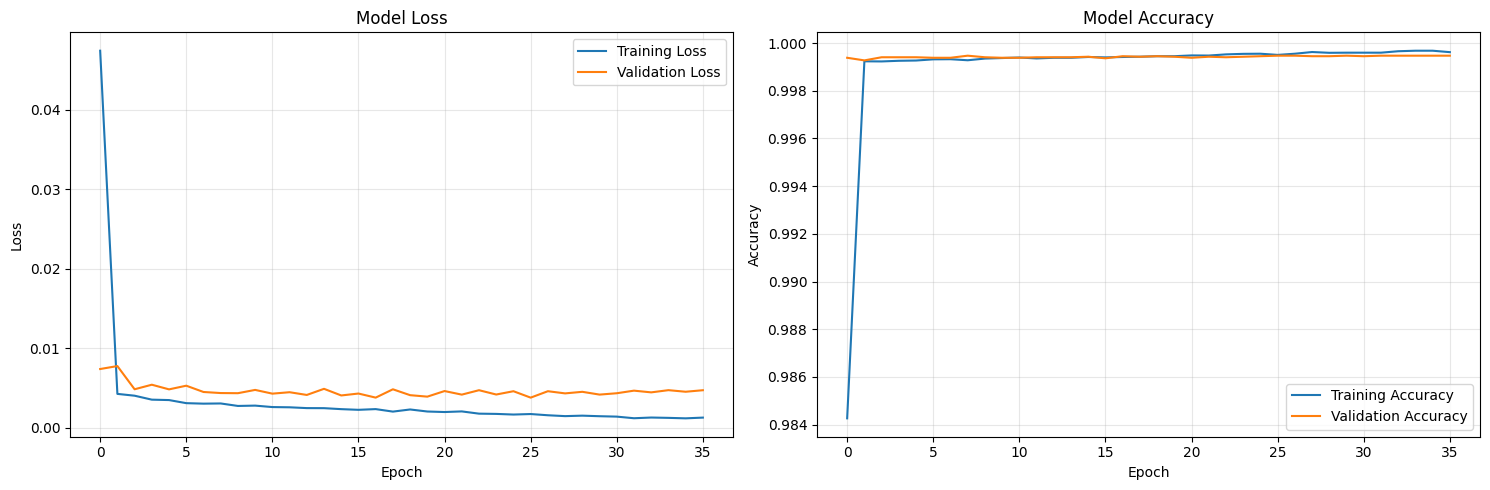

In [6]:
# Cell 6: Plot training history for best model
if best_params and 'history' in best_params['results']:
    fraud_detector.plot_training_history(best_params['results']['history'])
else:
    print("No best parameters found or no history available.")

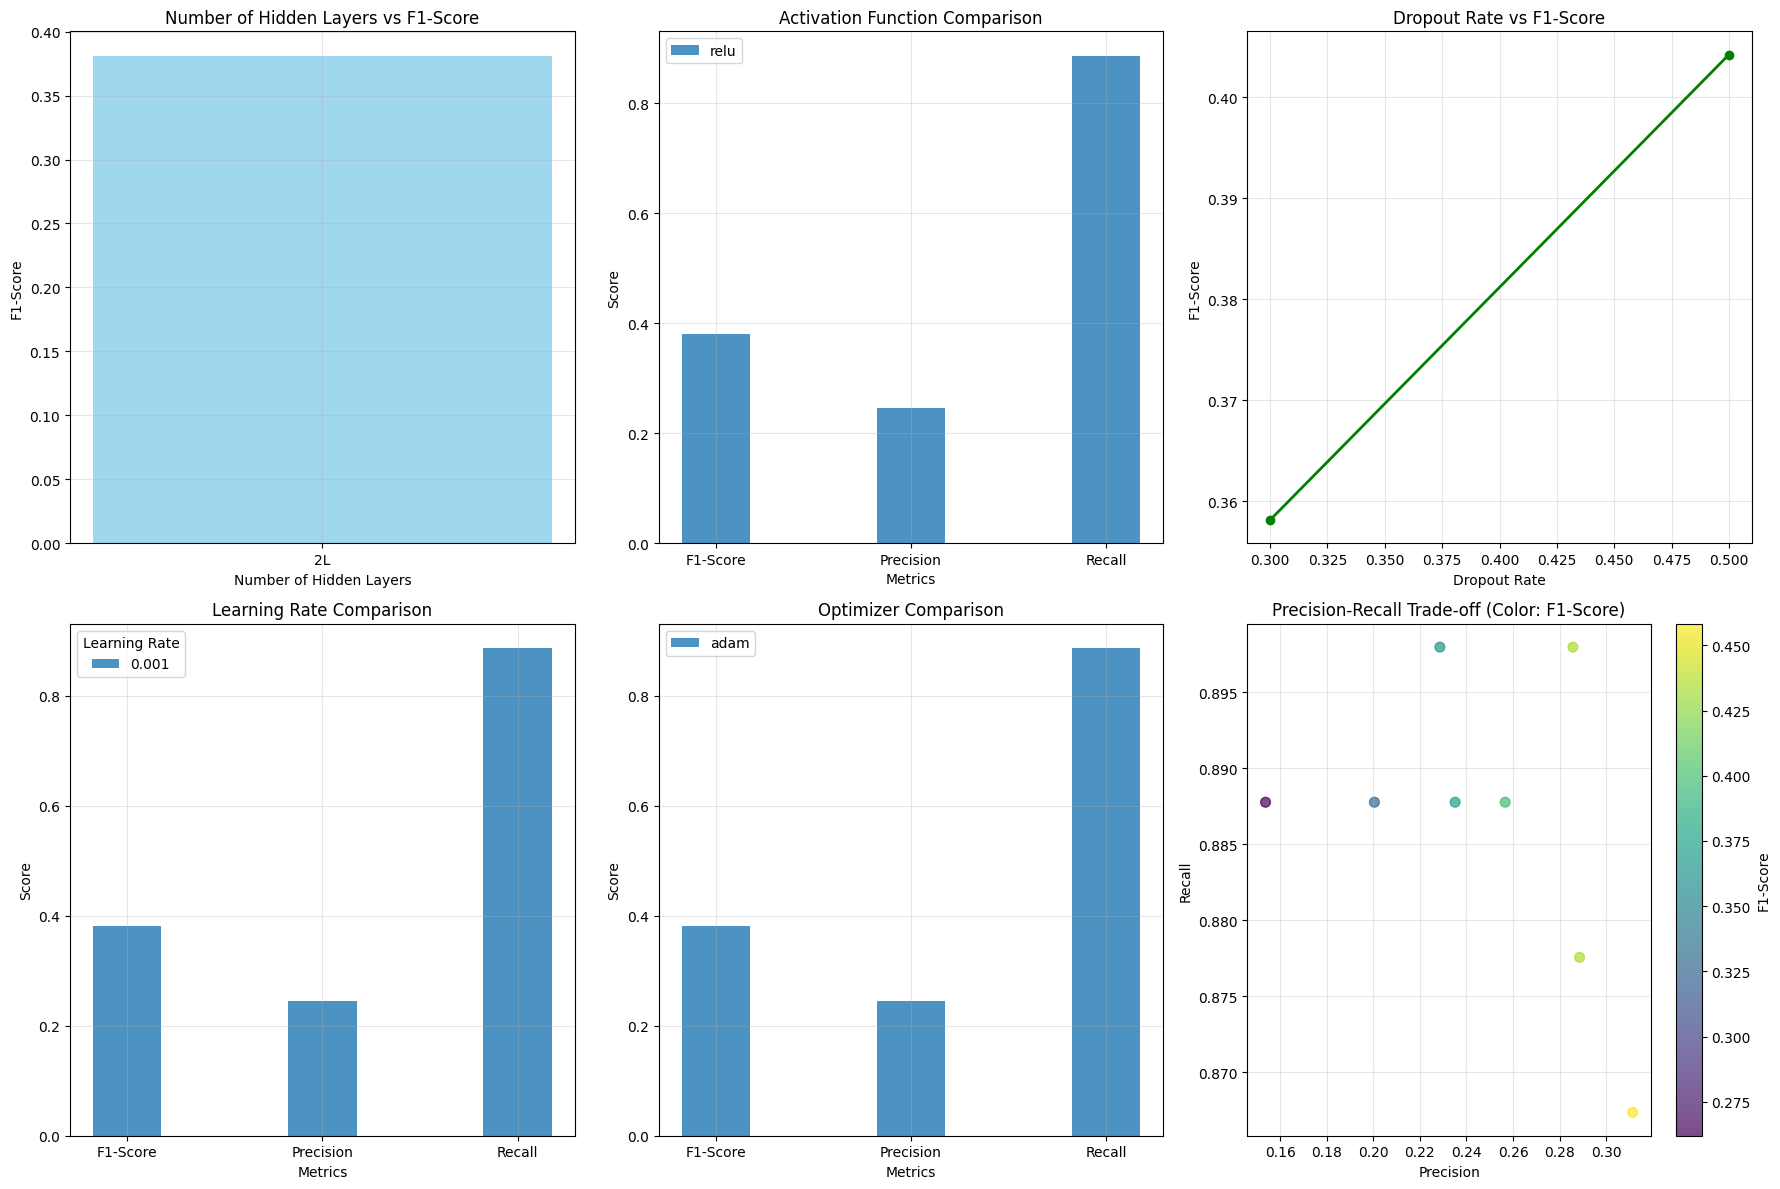

In [7]:
# Cell 7: Plot hyperparameter analysis
fraud_detector.plot_hyperparameter_analysis()

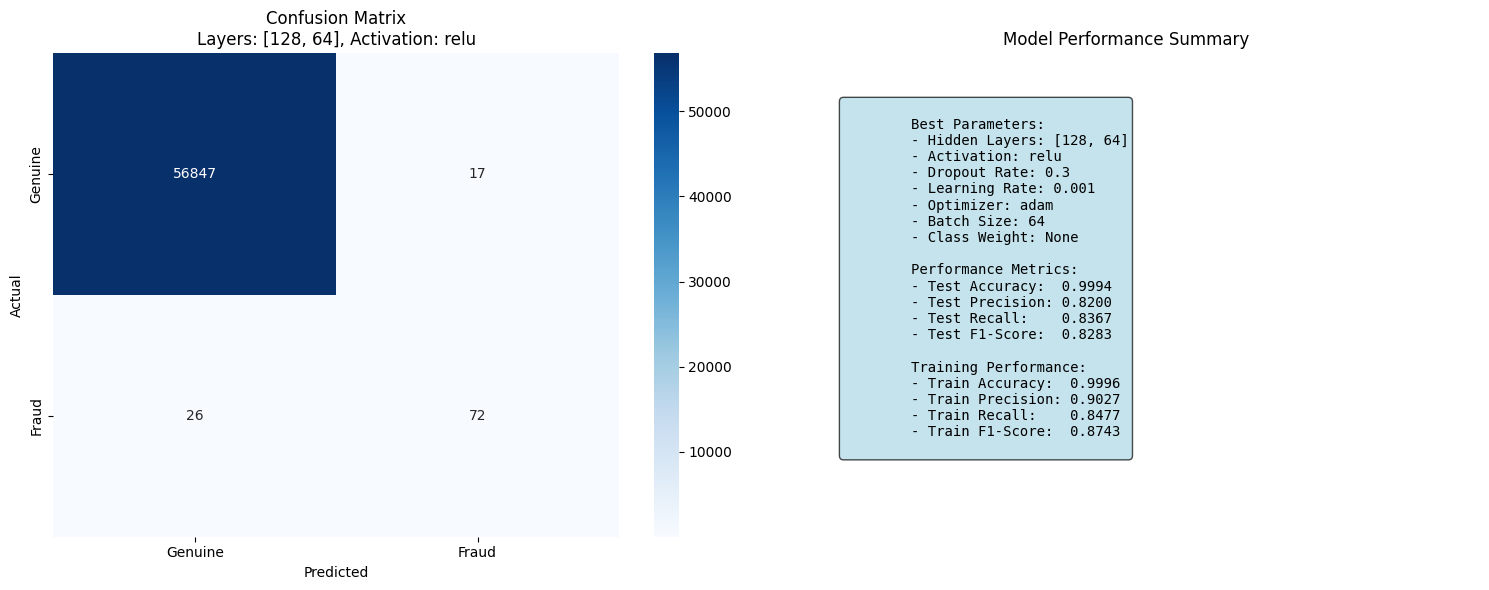

In [8]:
# Cell 8: Plot comprehensive confusion matrix
fraud_detector.plot_confusion_matrix_comprehensive()

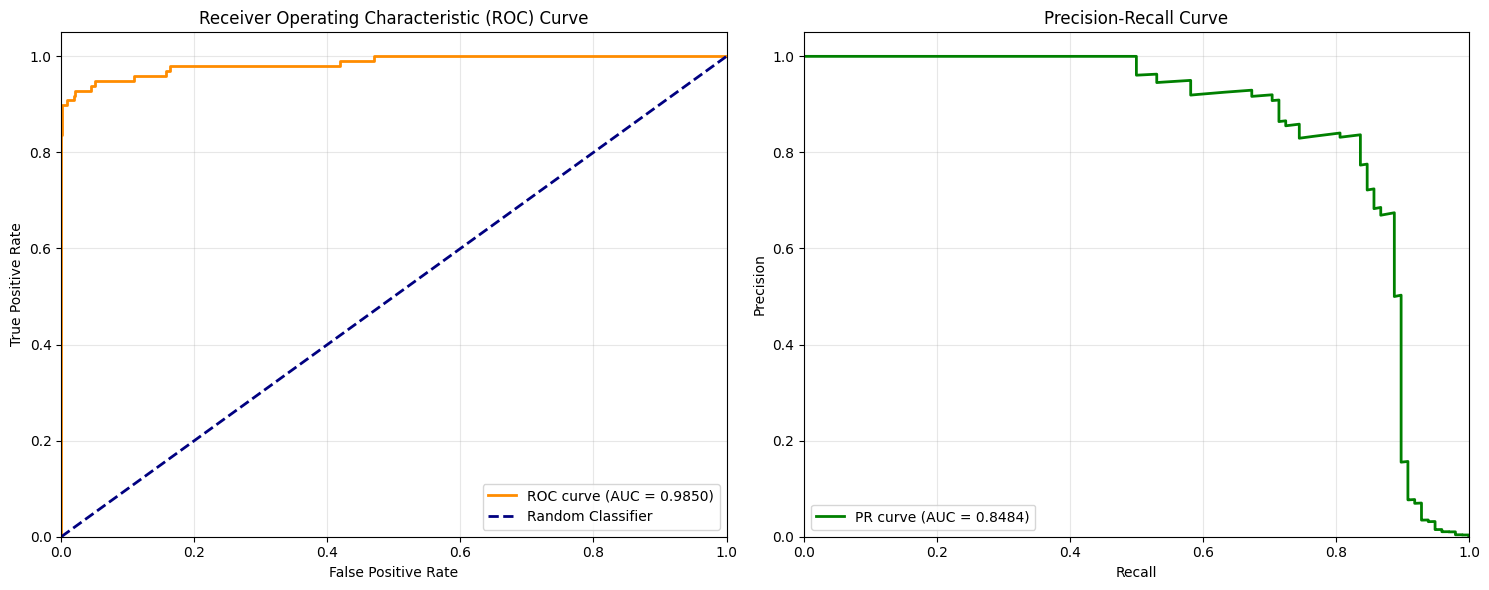

In [9]:
# Cell 9: Plot ROC and PR curves
fraud_detector.plot_roc_pr_curves()

In [10]:
# Cell 10: Print comprehensive report
fraud_detector.print_comprehensive_report()


COMPREHENSIVE CLASSIFICATION REPORT
Best Parameters:
  - Hidden Layers: [128, 64]
  - Activation: relu
  - Dropout Rate: 0.3
  - Learning Rate: 0.001
  - Optimizer: adam
  - Batch Size: 64
  - Class Weight: None

              precision    recall  f1-score   support

     Genuine       1.00      1.00      1.00     56864
       Fraud       0.79      0.83      0.81        98

    accuracy                           1.00     56962
   macro avg       0.90      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962


Test Set Performance:
Accuracy:  0.9994
Precision: 0.8200
Recall:    0.8367
F1-Score:  0.8283


In [11]:
# Cell 11: Print final summary
if best_params:
    print("\n" + "="*60)
    print("FINAL MODEL SUMMARY")
    print("="*60)
    results = best_params['results']
    print(f"Best Parameters:")
    print(f"  - Hidden Layers: {best_params['hidden_layers']}")
    print(f"  - Activation: {best_params['activation']}")
    print(f"  - Dropout Rate: {best_params['dropout_rate']}")
    print(f"  - Learning Rate: {best_params['learning_rate']}")
    print(f"  - Optimizer: {best_params['optimizer']}")
    print(f"  - Batch Size: {best_params['batch_size']}")
    print(f"  - Class Weight: {best_params['class_weight']}")
    print(f"\nTest Performance:")
    print(f"  - Accuracy:  {results['test_accuracy']:.4f}")
    print(f"  - Precision: {results['test_precision']:.4f}")
    print(f"  - Recall:    {results['test_recall']:.4f}")
    print(f"  - F1-Score:  {results['test_f1']:.4f}")
    
    print("\n" + "="*60)
    print("ANN PERFORMANCE ANALYSIS")
    print("="*60)
    print("Key Insights:")
    print("- ANN can capture complex non-linear patterns in the data")
    print("- Proper architecture design is crucial for performance")
    print("- Regularization techniques (dropout) prevent overfitting")
    print("- Learning rate and optimizer choice affect convergence")
    print("- Class weighting helps handle imbalanced datasets")
    print("- Feature scaling is essential for neural network performance")
else:
    print("\nHyperparameter tuning failed. Please check your data and try again.")


FINAL MODEL SUMMARY
Best Parameters:
  - Hidden Layers: [128, 64]
  - Activation: relu
  - Dropout Rate: 0.3
  - Learning Rate: 0.001
  - Optimizer: adam
  - Batch Size: 64
  - Class Weight: None

Test Performance:
  - Accuracy:  0.9994
  - Precision: 0.8200
  - Recall:    0.8367
  - F1-Score:  0.8283

ANN PERFORMANCE ANALYSIS
Key Insights:
- ANN can capture complex non-linear patterns in the data
- Proper architecture design is crucial for performance
- Regularization techniques (dropout) prevent overfitting
- Learning rate and optimizer choice affect convergence
- Class weighting helps handle imbalanced datasets
- Feature scaling is essential for neural network performance
